# Secondary Defensive Reaction Intelligence (SDRI)

## Motivations

It’s straightforward to measure reaction time and speed of players, and the NFL already does this in its Combine.  An Athletic Intelligence Quotient (AIQ) assessment involves measuring reaction times, among other traits, and speed can be measured in a simple 40-yard dash.  Although this can measure an athlete’s potential, it falls short in assessing how these talents translate to on-field performance.

Here's an example of a play with an ineffective reaction:
https://youtu.be/L_hlvNda2E8?t=3m40s

This comes from the Week 15 of the 2022 season between the Colts and Vikings, 1st quarter, 2nd & 9 with 35 seconds remaining.  Matt Ryan with the Colts throws to Michael Pittman Jr for a gain, but the player of interest here is Brian Asamoah II, #33, a linebacker from the Vikings.  In this play, Asamoah acted similar to a safety, looking at the Ryan to see where the play was going to go.  He correctly predicted the throw would go to his right, but he failed to move to the right *and deep*, the more precise spot the ball was heading.  When Ryan realized this and began dropping back, he had overshot his target and began to circle back.  This wasted movement is a risk for the defensive team.  

Knowing how quickly a defender recognizes a play won’t show you effectiveness in intercepting a receiver.  Tracking the first moment in which a player makes a correct movement will.


## Data Description and Preparation

The data used comes from a combination of pre-throw (up to 17 frames) and post-throw geospatial data from the 2023 season.  Each identified player had certain data available for each tenth of a second, or frame, of a game from the start of the game up until the time the ball was thrown or the throw ended.  For a specific player in a given game, I added their pre-throw data to their post-throw data (so long as their data existed in post-throw), and all frames were labeled in a continuous manner with a base frame of 0 when the ball was thrown.  The only relevant data kept from players for each frame were their identifying information and their x and y coordinates, with x stretching from 0 to 120 from the home endzone to visitor endzone and y stretching from 0 to 53.3 from the home sideline to the visitor sideline.  Additional play information was merged for each player’s frames, such as the x and y coordinates of a specified receiver for each corresponding frame, the x and y coordinates the ball would land in the corresponding play, and the direction the offense was heading.

This data acted as a base for more useful transformations.  Distances were calculated using the hypotenuse between x and y locations.  Player speed was calculated as the change of x and y positions between frames and acceleration as the change in speed between frames.  Directions such as the defender’s direction from the ending ball location and from the receiver were calculated using inverse tangents, or arctan2.  This fed into an angle tolerance in which a defender was deemed to be facing the direction of the ball if their angle of movement was within 10-45 degrees of the ball’s ending location depending on how close the defender was to the receiver, the closer pursuits requiring a smaller angle deviation.
    
Additionally, the distance between defender and ball ending location had a unit vector computed.  This was used alongside defender acceleration in a dot product to represent the defender’s acceleration towards the ball.  Lastly, and most important to this metric, if the defender was accelerating towards the ball and was within the angle tolerance threshold, it was deemed the defender had properly reacted.

To make data comparable, the first two frames of each play were discarded, and the angle of play was altered to account for the direction the offensive team was facing.  	


In [1]:
# PREPARE THE DATA

# import necessary libraries
import pandas as pd
import numpy as np 
from pathlib import Path
import os
import matplotlib.pyplot as plt

# store output from all games
all_file_results = []

# get the correct paths
data_dir = Path("/kaggle/input/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final")
train_path = data_dir / "train" #next(data_dir.glob("*/train"))

import warnings
warnings.filterwarnings('ignore')

# go through all of the files in the data folder
for i in range(1,19):
    # zero-pad to 2 digits
    week = f"{i:02d}"  

    # load in the files needed
    input_df = pd.read_csv(os.path.join(train_path,  f"input_2023_w{week}.csv"))
    output_df = pd.read_csv(os.path.join(train_path,  f"output_2023_w{week}.csv"))

    # add unique names
    #names.append(input_df[['nfl_id', 'player_name']].drop_duplicates())

    # I only care about target players and their data for merging
    input_df = input_df[input_df['player_to_predict'] == True]

    # coerce differences in formatting
    for df in [input_df, output_df]:
        for k in ["game_id", "play_id"]:
            if k in df.columns:
                df.loc[:, k] = pd.to_numeric(df[k], errors="coerce").astype("Int64")

    # get the place the ball lands
    ball_land = (
        input_df[["game_id", "play_id", "ball_land_x", "ball_land_y"]] # select landing cols
                .dropna(subset=["ball_land_x", "ball_land_y"])         # require both coords
                .drop_duplicates(["game_id", "play_id"])               # one landing per play
    )

    # get the direction and player position
    extras = input_df[['game_id', 'play_id', 'nfl_id', 'player_name', 'player_position', 'play_direction']] \
        .groupby(['game_id', 'play_id', 'nfl_id']).max().reset_index()

    # make a frame_id for the total play
    input_df['frame_id_adj'] = input_df['frame_id']
    
    ### focuses on defense
    # selected data from input_df I want to merge, basically the predicted player for a single game
    defensive_merge = input_df[input_df['player_role'] == 'Defensive Coverage'] \
        [['game_id','play_id', 'nfl_id', 'frame_id', 'x', 'y', 'frame_id_adj']] \
            .groupby(['game_id', 'play_id', 'nfl_id', 'frame_id']).max().reset_index() \
            .groupby(['game_id', 'play_id', 'nfl_id']) \
            .tail(17)

    # gets the maximum frame number for input files
    input_max_frames = defensive_merge[['game_id','play_id', 'nfl_id', 'frame_id_adj']] \
        .groupby(['game_id', 'play_id', 'nfl_id']).max().reset_index()

    # adds the maximum frame number to the output dataframe
    output_mod = pd.merge(output_df, input_max_frames, \
                        on = ['game_id', 'play_id', 'nfl_id'], how = 'inner', suffixes=('', '_max'))

    # adjusts the frame_id to be continuous across the play
    output_mod['frame_id_adj'] = output_mod['frame_id_adj'] + output_mod['frame_id']

    # put it all together
    defensive_combined = pd.concat([defensive_merge, output_mod], ignore_index=True)

    ### focuses on offense
    # selected data from input_df I want to merge, basically the predicted player for a single game
    offensive_merge = input_df[input_df['player_role'] == 'Targeted Receiver'] \
        [['game_id','play_id', 'nfl_id', 'frame_id', 'x', 'y', 'frame_id_adj']] \
            .groupby(['game_id', 'play_id', 'nfl_id', 'frame_id']).max().reset_index() \
            .groupby(['game_id', 'play_id', 'nfl_id']) \
            .tail(17)

    # gets the maximum frame number for input files
    input_max_frames = offensive_merge[['game_id','play_id', 'nfl_id', 'frame_id_adj']] \
        .groupby(['game_id', 'play_id', 'nfl_id']).max().reset_index()

    # adds the maximum frame number to the output dataframe
    output_mod = pd.merge(output_df, input_max_frames, \
                        on = ['game_id', 'play_id', 'nfl_id'], how = 'inner', suffixes=('', '_max'))

    # adjusts the frame_id to be continuous across the play
    output_mod['frame_id_adj'] = output_mod['frame_id_adj'] + output_mod['frame_id']

    # put it all together
    offensive_combined = pd.concat([offensive_merge, output_mod], ignore_index=True)

    ## merge offenseive and defensive data together
    combined = pd.merge(defensive_combined, offensive_combined[['game_id', 'play_id', 'frame_id_adj', 'x', 'y']], 
                    on=['game_id', 'play_id', 'frame_id_adj'], suffixes=('_def', '_off'))
    combined = pd.merge(combined, ball_land, on=['game_id', 'play_id'], how='left')

    # add in extra data
    #combined = pd.merge(combined, extras, on=['game_id', 'play_id', 'nfl_id'], how='left')


    # make sure all the values are sorted
    combined = combined.sort_values(["game_id", "play_id", "nfl_id", "frame_id_adj"])

    # get the speed
    combined['dx'] = combined['x_def'].diff()
    combined['dy'] = combined['y_def'].diff()
    combined['speed'] = np.sqrt(combined['dx']**2 + combined['dy']**2)

    # get the acceleration
    combined['acceleration'] = combined['speed'].diff() #np.sqrt(combined['ddx']**2 + combined['ddy']**2)

    # get the direction as an angle that the player is traveling
    combined['dir_rad'] = np.arctan2(combined['dy'], combined['dx'])
    combined['dir_degree'] = (np.degrees(combined['dir_rad']) + 360) % 360

    # get the direction from player to ball landing spot
    combined['to_ball_dir'] = np.degrees(np.arctan2(combined['ball_land_y'] - combined['y_def'], 
                                                    combined['ball_land_x'] - combined['x_def']))
    combined['to_ball_dir'] = (combined['to_ball_dir'] + 360) % 360

    # get the distance between defender and receiver
    combined['dist_def_off'] = np.sqrt((combined['x_def'] - combined['x_off'])**2 + 
                                    (combined['y_def'] - combined['y_off'])**2)

    # make vector from defender to ball landing spot
    combined['to_rx'] = combined['ball_land_x'] - combined['x_def']
    combined['to_ry'] = combined['ball_land_y'] - combined['y_def']

    # unit vector towards ball landing spot
    combined['dist_to_ball'] = np.sqrt(combined['to_rx']**2 + combined['to_ry']**2)
    combined['ux'] = combined['to_rx'] / combined['dist_to_ball']
    combined['uy'] = combined['to_ry'] / combined['dist_to_ball']

    # accel vector components
    combined['ax'] = combined['acceleration'] * np.cos(combined['dir_rad'])
    combined['ay'] = combined['acceleration'] * np.sin(combined['dir_rad'])

    # finally, a dot product
    combined['accel_towards_ball'] = combined['ax'] * combined['ux'] + combined['ay'] * combined['uy']

    combined_final = (
        combined
            #.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']) # should already be sorted
            .groupby(['game_id', 'play_id', 'nfl_id'])
            .apply(lambda g: g.iloc[2:])  # drop first 2 rows in each group
            .reset_index(drop=True)
    )

    input_max_frames.rename(columns={'frame_id_adj': 'rel_frame_id'}, inplace=True)

    # get the max number of frame for the input => needed when a throw is made in < 1.7 seconds
    combined_f = pd.merge(combined_final, input_max_frames, on=['game_id', 'play_id'], how='left')
    # type => 0 is before throw, 1 is after throw
    combined_f['rel_frame_id'] = combined_f['frame_id_adj'] - combined_f['rel_frame_id']

    # create the angle difference between player direction and ball direction
    combined_f['angle_dif'] = np.abs(combined_f['dir_degree'] - combined_f['to_ball_dir'])
    combined_f['angle_dif'] = combined_f['angle_dif'].apply(lambda x: min(x, 360 - x))
    # create tolerance based on distance from receiver
    combined_f['angle_tol'] = np.clip(2 * combined_f['dist_def_off'] + 5, 10, 45)

    combined_f['reaction'] = ((combined_f['accel_towards_ball'] > 0) & 
                            (combined_f['angle_dif'] < combined_f['angle_tol'])).astype(int)

    reaction_results = combined_f[combined_f['reaction'] == 1].groupby(['game_id', 'play_id', 'nfl_id_x']) \
        [['reaction', 'rel_frame_id']].min().reset_index()
    lacking = combined_f[combined_f['reaction'] == 0].groupby(['game_id', 'play_id', 'nfl_id_x']) \
        [['reaction', 'rel_frame_id']].max().reset_index()

    # combine
    final_results = pd.concat([reaction_results, lacking]).drop_duplicates(subset=["play_id", "nfl_id_x"])

        # for data insights later... find the distance, angle from receiver at time of throw
    zero_frame = combined_f[combined_f['rel_frame_id'] == 0][['game_id', 'play_id', 'nfl_id_x',
                                                            'dist_def_off', 'dir_degree']]
    #zero_frame = combined_f.groupby(['game_id', 'play_id', 'nfl_id_x']).first().reset_index() \
    #    [['game_id', 'play_id', 'nfl_id_x','dist_def_off', 'dir_degree']]
    alt_final_results = pd.merge(final_results, zero_frame, on=['game_id', 'play_id', 'nfl_id_x'], how='left')
    #alt_final_results.rename(columns={'nfl_id_x': 'nfl_id'}, inplace=True)

    # add in extra data
    #alt_final_results = pd.merge(alt_final_results, extras, on=['game_id', 'play_id', 'nfl_id'], how='left')
    alt_final_results2 = pd.merge(
        alt_final_results, extras, 
        left_on=['game_id', 'play_id', 'nfl_id_x'],
        right_on=['game_id', 'play_id', 'nfl_id'],
        how='left'
    )

    # cherry on top, combine from prior
    all_file_results.append(alt_final_results2)
    # print(f"Week {week} processed")
#print("All weeks processed")

# concatenate files
df = pd.concat(all_file_results, ignore_index=True)

# alter the dir_degree based on play direction
df['dir_degree'] = np.where(
    df['play_direction'] == 'left',
    (df['dir_degree'] + 180) % 360,
    df['dir_degree']
)

## Method Design

The metric I am creating is the Secondary Defensive Reaction Intelligence (SDRI).  This is continuous metric which measures secondary defenders’ average time in tenths of a second to make an efficient reaction to the quarterback throwing a ball.

A valid play to be included in this measurement consists of a defender playing a deep or QB-facing coverage role (in this case as provided in the output files) and shows their first efficient reaction (or lack thereof) after the ball has been thrown.  A reaction beforehand would be classified as anticipation.*  The first frame flagged as an effective reaction of a valid play is the reaction time (RTV).  When a player has no valid reaction time, a penalty weight of 1.5x is multiplied by the throw length in seconds to calculate an estimated reaction time instead (RTP).

SDRI = ( sum(RTV) + sum(RTP) ) / ( count(RTV) + count(RTP) )

    *Note: Judging the exact moment that should be considered anticipation based upon ball movement is tricky.  Human reaction times are likely no faster than 0.1s, but there is also a minimal amount of time needed to throw a ball.  Should the reaction time begin once the ball has been released from the QBs hands?  Should it begin when the QB is making a throwing motion?  This doesn’t have a clear best answer, but for sake of simplicity, I am suggesting that these defenders can process visual stimuli from the QB’s motion to throw and reaction by the first frame after the ball has been thrown


In [2]:
# CALCULATE SDRI

# function to compute first wave of stats for each defender
def compute_stats(group):
    rel = group['rel_frame_id']
    react = group['reaction']
    
    return pd.Series({
        # counts
        'count_entries': len(rel),
        'anticipation': ((react == 1) & (rel <= 0)).sum(),
        'reaction_count': ((react == 1) & (rel > 0)).sum(),
        'nr_count': (react == 0).sum(),

        # average reaction times
        'avg_reaction_time': rel[react == 1].mean(),
        'avg_reaction_time_valid': rel[(react == 1) & (rel > 0)].mean(),
        'avg_nr_time': rel[react == 0].mean()
    })

# create stats
final = df.groupby(['nfl_id', 'player_name', 'player_position']).apply(compute_stats).reset_index()

# only select qualified defenders with enough entries
qualified_final = final[final['reaction_count'] >= 8].copy()

# adding a penalty of 1.5x the throw time for no reactions
qualified_final['avg_nr_time'] = qualified_final['avg_nr_time'].fillna(0)
qualified_final['nr_penalty'] = qualified_final['avg_nr_time'] * 1.5

# get reaction and anticipation percentages
qualified_final['reaction_pct'] = qualified_final['reaction_count'] / (qualified_final['count_entries'] - qualified_final['nr_count']) 
qualified_final['anticipation_pct'] = qualified_final['anticipation'] / (qualified_final['count_entries'] - qualified_final['nr_count'])

# calculate a final score
# calculated as mean of valid reaction times and penalized no-reaction times combined
qualified_final['reaction_score'] = qualified_final['avg_reaction_time_valid'] + qualified_final['nr_penalty'] * (1 - (qualified_final['nr_count'] / qualified_final['count_entries']))

## Results and Interpretations

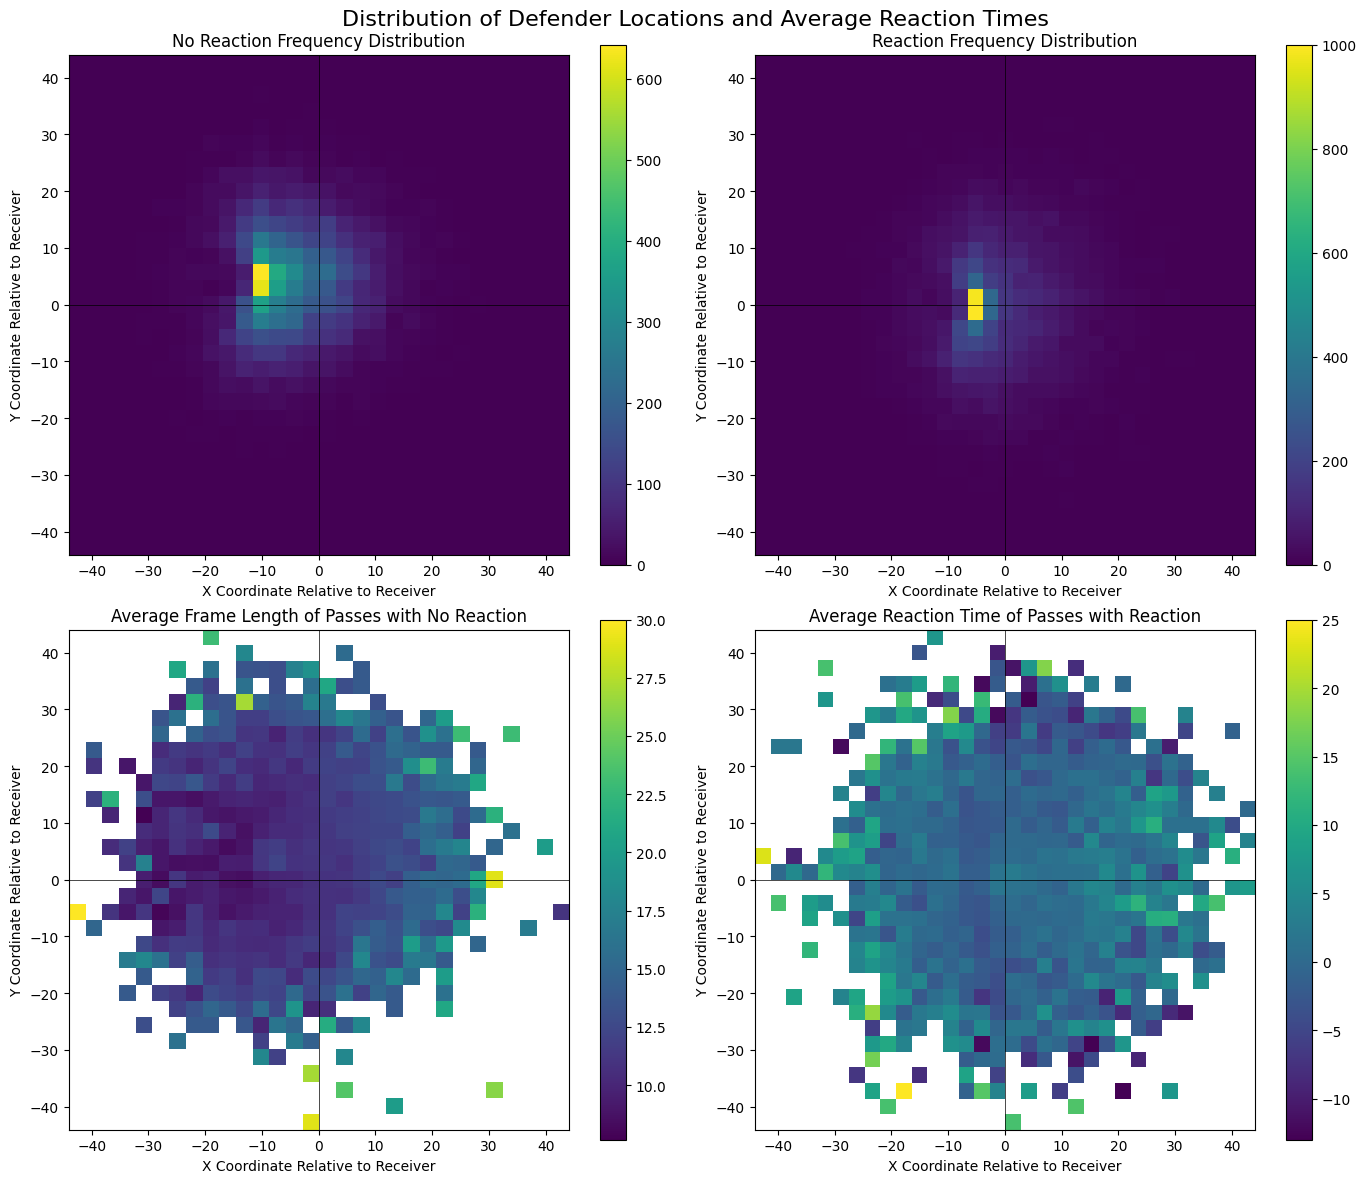

In [3]:
# CREATE HEATMAPS

# convert polar back to cartesian
df["theta_rad"] = np.deg2rad(df["dir_degree"])
df["x"] = df["dist_def_off"] * np.cos(df["theta_rad"])
df["y"] = df["dist_def_off"] * np.sin(df["theta_rad"])

# define grid resolution
xbins = 50
ybins = 50

max_range = max(df["x"].abs().max(), df["y"].abs().max())
x_edges = np.linspace(-max_range, max_range, xbins + 1)
y_edges = np.linspace(-max_range, max_range, ybins + 1)

# bin the data
df["x_bin"] = np.digitize(df["x"], x_edges) - 1
df["y_bin"] = np.digitize(df["y"], y_edges) - 1

extent = [-max_range, max_range, -max_range, max_range]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ------------------------------
# Top row: Frequency
# ------------------------------
# Reaction = 0
heatmap_freq0 = df[df['reaction'] == 0].groupby(['y_bin', 'x_bin']).size().unstack().fillna(0)
im00 = axes[0, 0].imshow(heatmap_freq0, origin='lower', aspect='equal', extent=extent)
axes[0, 0].set_title("No Reaction Frequency Distribution")
axes[0, 0].set_xlabel("X Coordinate Relative to Receiver")
axes[0, 0].set_ylabel("Y Coordinate Relative to Receiver")
fig.colorbar(im00, ax=axes[0, 0])

# Reaction = 1
heatmap_freq1 = df[df['reaction'] == 1].groupby(['y_bin', 'x_bin']).size().unstack().fillna(0)
im01 = axes[0, 1].imshow(heatmap_freq1, origin='lower', aspect='equal', extent=extent)
axes[0, 1].set_title("Reaction Frequency Distribution")
axes[0, 1].set_xlabel("X Coordinate Relative to Receiver")
axes[0, 1].set_ylabel("Y Coordinate Relative to Receiver")
fig.colorbar(im01, ax=axes[0, 1])

# ------------------------------
# Bottom row: Average score
# ------------------------------
# Reaction = 0
heatmap_score0 = df[(df['reaction'] == 0) & (df['rel_frame_id'] > -14)].groupby(['y_bin','x_bin'])['rel_frame_id'].mean().unstack()
im10 = axes[1, 0].imshow(heatmap_score0, origin='lower', aspect='equal', extent=extent)
axes[1, 0].set_title("Average Frame Length of Passes with No Reaction")
axes[1, 0].set_xlabel("X Coordinate Relative to Receiver")
axes[1, 0].set_ylabel("Y Coordinate Relative to Receiver")
fig.colorbar(im10, ax=axes[1, 0])

# Reaction = 1
heatmap_score1 = df[(df['reaction'] == 1) & (df['rel_frame_id'] > -14)].groupby(['y_bin','x_bin'])['rel_frame_id'].mean().unstack()
im11 = axes[1, 1].imshow(heatmap_score1, origin='lower', aspect='equal', extent=extent)
axes[1, 1].set_title("Average Reaction Time of Passes with Reaction")
axes[1, 1].set_xlabel("X Coordinate Relative to Receiver")
axes[1, 1].set_ylabel("Y Coordinate Relative to Receiver")
fig.colorbar(im11, ax=axes[1, 1])

# Optional crosshairs at 0,0 for all
for ax_row in axes:
    for ax in ax_row:
        ax.axhline(0, color='black', linewidth=0.5)
        ax.axvline(0, color='black', linewidth=0.5)

#plt.title('Distribution of Defender Locations and Average Reaction Times', fontsize=14)
fig.suptitle("Distribution of Defender Locations and Average Reaction Times", fontsize=16)

plt.tight_layout()
plt.show()

This graph shows heatmaps of the distribution of defender locations relative to a receiver at the time of reaction or end of play, and the average reaction or throw time at each location.  A few things are interesting from this.  First, it doesn’t appear that distance from receiver tends to have an impact on reaction time.  Reaction times are consistent throughout the heat map.  Secondly, we can see when looking at the no reaction heat maps that failing to react is correlated with faster throws.  This hints that there were likely many situations where the defender did end up reacting, but not while the ball was in air.  This discovery supported the penalty being introduced for these no-reaction plays rather than their omission from the calculation.

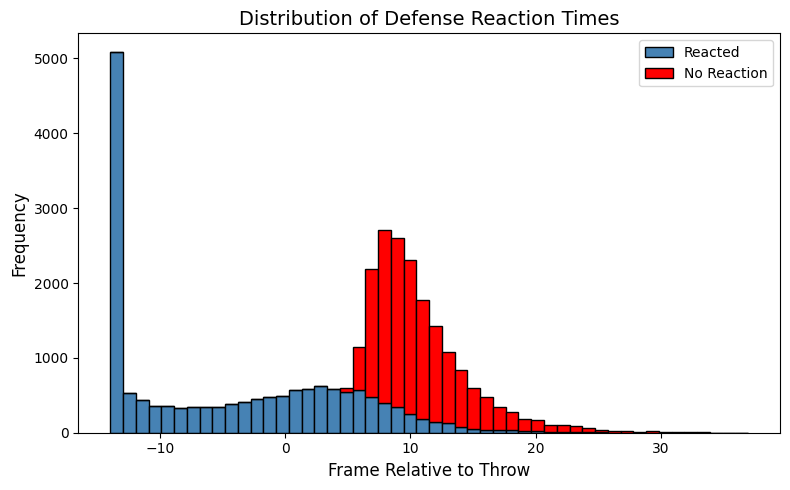

In [4]:
# CREATE DISTRIBUTIONS

# create visualization
plt.figure(figsize=(8, 5))

# Prepare the data split by category
data = [
    df.loc[(df['reaction'] == 1), 'rel_frame_id'],
    df.loc[(df['reaction'] == 0), 'rel_frame_id']
]


# plot a stacked histogram
plt.hist(
    data,
    bins=50,
    stacked=True,
    color=['steelblue', 'red'],
    edgecolor='black',
    label=['Reacted', 'No Reaction']
)

# labels and styling
plt.title('Distribution of Defense Reaction Times', fontsize=14)
plt.xlabel('Frame Relative to Throw', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

plt.grid(False)
plt.tight_layout()
plt.show()

This shows the distribution of reaction times, and most strikingly we can see how many players began reacting well before the ball had been thrown.  These likely stem from playing man coverage or incredible play awareness and foresight.  As mentioned earlier though, these are excluded from our analysis in reaction time.  The no-reactions peak heavily around 0.7-1.1s zone, suggesting that most missed reactions may have simply been slow reactions.  For those who reacted during the throw without foresight or following the receiver, a peak in distribution seems to be around 0.3s, which is an impressive but realistic reaction time for a professional athlete, especially considering the “starting frame” the defender has visual stimuli of the QB about to throw is before the 0 frame.

In [5]:
# GET DEFENDER'S SCORES
# I uploaded an image of these rather than print the code, but this is how
# you could print the code
#qualified_defenders = qualified_final \
#    .sort_values(by='reaction_score', ascending=True).reset_index().copy()
#qualified_defenders[['player_name', 'player_position', 'reaction_score', 'reaction_count']]

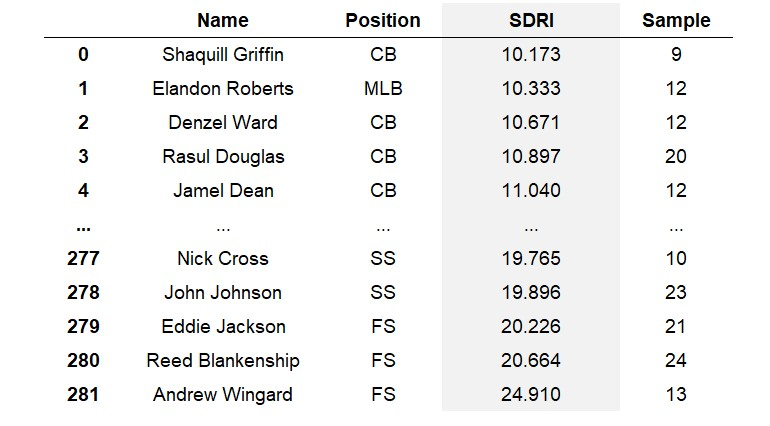

In [6]:
# Display Image
from IPython.display import Image, display

display(Image("/kaggle/input/resultimage/sample_SDRI_results.jpg", width=600))

These show, from the data we have in the 2023 season, the defenders with the best and worst SDRI scores.  The top positions appear to be dominated by Cornerbacks with the top scores near a one-second average reaction and Free and Strong Safeties coming in last with a two-plus second reaction.  

## Discussion and Game Implications

This should be used jointly with a corresponding foresight metric.  A “perfect” player may not appear in this reaction metric as they would be able to foresee every play.  Perhaps players should strive to be in this category, but this isn’t a realistic standard.  Measuring how an athlete reacts to unexpected plays, complex plays, or even plays where a QB threw to a different receiver or zone is as important as it is inevitable, and this metric excels at calculating that.

A team may want to acquire a Safety who is fast and has a quick reaction time, for example.  Everything may look great on paper for this defender; however, you may find that he has a lot of wasted movement and frequently needs to backtrack his steps which results in a larger SDRI.  Another Safety may be slower on paper, but he is much more efficient in how he reacts to plays, resulting in a smaller SDRI.  This slower Safety may actually intercept a receiver faster, and since he looks worse using old metrics too, a team may acquire him at a lower price.

This intuitively should be a gold standard for coaches when prospecting athletes: using in-game data to predict in-game performance.  Controlled experiments such as the combine are *indicators* of in-game performance, not actual in-game performance results.  Although those metrics are popular as they have the advantage of being better isolated and perhaps more comparable, they can miss in-game nuances the SDRI includes.

## Limitations and Future Work

This metric is far from perfect, largely because the difference between foresight, chance, and reaction is a gray area.  It’s difficult in certain situations to determine if a defender identified a receiver to follow due to a predefined plan, context within the game, or an indication that the QB was about to throw to the respective receiver.  It’s possible that a poor reaction while playing man coverage can be confused with a superb SDRI score.  It’s also difficult to say whether the defender moved in a correct direction by intent or happenstance.  Certain defenders may be unjustly penalized due to the ball landing in an unexpected area, such as being tipped or swatted away, or they may have a valid, strategic purpose for not approaching the ball’s landing area as we would expect.  As well, other defenders can be penalized for giving up on unwinnable plays such as if the defender had already made it to the endzone, are heading out of bounds, or there are too many cooks in the kitchen so to say.

I believe future work can address some of these limitations.  For instance, a large number of plays had no effective reaction from the defenders, and figuring out why can help determine if our reaction inclusion thresholds were appropriate.

Perhaps some of these plays resulted from defenders having obstructed paths to reach the receiver or a defender ran deep to be backup for closer defenders.  These may be situations where the defenders had great reactions and field awareness, but it didn’t appear in the data.  Others could be from unwinnable cases as described earlier.  It also may be the case that there is a third distribution in reaction times for after the ball has been caught where pre-occupied defenders react after the play happens.  Having geospatial data once the ball is out of the air would be beneficial in correct classification of these types of defender movements.  These plays can be filtered out or adjusted for in future iterations, keeping the core methodology largely the same.

Future work will also need to consider a fundamental concern with the aggregation versus granularity trade off.  Sport scientists can attempt to isolate certain situations and determine how well a player performed relative to an expected benchmark, in this context perhaps evaluating a defender’s given reaction time relative to the expected reaction time from other defenders in identical situations.  This is one direction my recommendation points, and to some this may be an ideal standard; but it too comes with limitations.  Entanglement effects such as the mere existence of a particular defender over another can change a play, let alone how the movement of a defender can change the decision of a QB.  The more variables we try to account for, the smaller the comparable group will be – and if this group gets too small, it can cease to be a useful metric.
